In [1]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated
import operator
import os

print("All imports successful")

c:\Users\DELL\Desktop\Exercises\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful


In [2]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

if not openai_api_key:
    raise ValueError("OPENAI_API_KEY not found!")

print("API key loaded")

API key loaded


In [3]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    api_key=openai_api_key
)

print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


In [7]:
@tool
def generate_ideas(topic: str) -> str:
    """Generate 3-5 key points about a topic for blog content."""
    ideas = {
        "machine learning": [
            "Machine learning is a subset of AI that enables systems to learn from data",
            "Common ML algorithms include linear regression, decision trees, and neural networks",
            "Applications range from image recognition to natural language processing",
            "Key challenges include data quality, model interpretability, and bias mitigation",
            "The field continues to evolve with deep learning and reinforcement learning advances"
        ],
        "python programming": [
            "Python is known for its simplicity and readability",
            "It has extensive libraries for data science, web development, and automation",
            "Python supports multiple programming paradigms",
            "The language has a large, active community and ecosystem",
            "Python is widely used in education, research, and industry"
        ],
        "multi-agent systems": [
            "Multi-agent systems consist of multiple interacting agents",
            "Agents can be autonomous, reactive, or proactive",
            "Communication and coordination are key challenges",
            "Applications include robotics, simulation, and distributed problem solving",
            "Design patterns include supervisor, collaborative, and hierarchical structures"
        ]
    }
    
    topic_lower = topic.lower()
    for key, value in ideas.items():
        if key in topic_lower:
            return f"Generated ideas: {chr(10)}- " + f"{chr(10)}- ".join(value)
    
    default_ideas = [
        f"{topic} is a significant area of study with diverse applications",
        f"Key aspects include fundamental principles and practical implementations",
        f"Recent advancements have expanded capabilities in {topic}",
        f"Common challenges involve scalability and real-world adaptation",
        f"Future directions include integration with emerging technologies"
    ]
    return f"Generated ideas: {chr(10)}- " + f"{chr(10)}- ".join(default_ideas)

print("generate_ideas tool created")

generate_ideas tool created


In [8]:
@tool
def draft_content(ideas: str) -> str:
    """Create a structured blog post draft from provided ideas."""
    intro = "INTRODUCTION: This blog post explores key insights and perspectives on the topic. The following sections provide comprehensive analysis and practical examples."
    
    body = "MAIN CONTENT: Based on the provided ideas, this section elaborates on core concepts and their applications. Each idea is expanded with detailed explanations and relevant examples to enhance understanding."
    
    conclusion = "CONCLUSION: The discussed concepts demonstrate the significance and impact of this topic. Future developments and practical considerations are also highlighted for continued learning and application."
    
    draft = f"{intro}{chr(10)}{chr(10)}{body}{chr(10)}{chr(10)}{conclusion}{chr(10)}{chr(10)}Incorporated ideas: {ideas}"
    
    return f"Blog draft: {draft}"

print("draft_content tool created")

draft_content tool created


In [9]:
@tool
def improve_writing(draft: str) -> str:
    """Polish and refine blog draft for clarity and professional quality."""
    improvements = [
        "Enhanced clarity and flow of the content",
        "Improved sentence structure and readability",
        "Added transitional phrases for better coherence",
        "Refined language for professional tone",
        "Ensured consistent formatting throughout"
    ]
    
    polished = f"POLISHED VERSION:{chr(10)}{draft}{chr(10)}{chr(10)}Improvements made:{chr(10)}- " + f"{chr(10)}- ".join(improvements)
    
    return f"Final polished content: {polished}"

print("improve_writing tool created")

improve_writing tool created


In [10]:
class ContentState(TypedDict):
    messages: Annotated[list, operator.add]
    topic: str
    ideas: str
    draft: str
    final_output: str

print("ContentState defined")

ContentState defined


In [11]:
brainstormer_prompt = SystemMessage(content="You are a brainstorming specialist. Use generate_ideas tool to create key points about the topic. Focus on generating comprehensive ideas.")

brainstormer_llm = llm.bind_tools([generate_ideas])

def brainstormer_agent(state: ContentState) -> dict:
    topic = state["topic"]
    messages = [
        brainstormer_prompt,
        HumanMessage(content=f"Generate ideas for blog post about: {topic}")
    ]
    
    response = brainstormer_llm.invoke(messages)
    
    ideas_result = ""
    if response.tool_calls:
        print("Brainstormer: Using generate_ideas tool")
        tool_call = response.tool_calls[0]
        ideas_result = generate_ideas.invoke(tool_call["args"])
    else:
        ideas_result = response.content
    
    print("Brainstormer generated ideas")
    
    return {
        "messages": [AIMessage(content=f"Brainstormer ideas: {ideas_result}")],
        "ideas": ideas_result
    }

print("Brainstormer agent created")

Brainstormer agent created


In [12]:
writer_prompt = SystemMessage(content="You are a writing specialist. Use draft_content tool to create a structured blog post from ideas. Create organized content with proper sections.")

writer_llm = llm.bind_tools([draft_content])

def writer_agent(state: ContentState) -> dict:
    ideas = state["ideas"]
    
    print("Writer: Using draft_content tool")
    draft_result = draft_content.invoke({"ideas": ideas})
    
    print("Writer created draft")
    
    return {
        "messages": [AIMessage(content=f"Writer draft: {draft_result}")],
        "draft": draft_result
    }

print("Writer agent created")

Writer agent created


In [13]:
editor_prompt = SystemMessage(content="You are an editing specialist. Use improve_writing tool to polish and refine the draft. Focus on clarity, flow, and professional quality.")

editor_llm = llm.bind_tools([improve_writing])

def editor_agent(state: ContentState) -> dict:
    draft = state["draft"]
    
    print("Editor: Using improve_writing tool")
    final_result = improve_writing.invoke({"draft": draft})
    
    print("Editor polished content")
    
    return {
        "messages": [AIMessage(content=f"Final output: {final_result}")],
        "final_output": final_result
    }

print("Editor agent created")

Editor agent created


In [14]:
content_builder = StateGraph(ContentState)

content_builder.add_node("brainstormer", brainstormer_agent)
content_builder.add_node("writer", writer_agent)
content_builder.add_node("editor", editor_agent)

content_builder.add_edge(START, "brainstormer")
content_builder.add_edge("brainstormer", "writer")
content_builder.add_edge("writer", "editor")
content_builder.add_edge("editor", END)

content_system = content_builder.compile()

print("Content creation pipeline created")

Content creation pipeline created


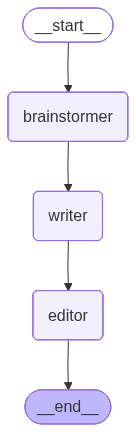

In [15]:
try:
    display(Image(content_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START -> brainstormer -> writer -> editor -> END")

In [16]:
result = content_system.invoke({
    "topic": "Create a blog post about machine learning",
    "messages": []
})

print("=" * 70)
print("FINAL OUTPUT:")
print("=" * 70)
print(result["final_output"])
print("=" * 70)

Brainstormer: Using generate_ideas tool
Brainstormer generated ideas
Writer: Using draft_content tool
Writer created draft
Editor: Using improve_writing tool
Editor polished content
FINAL OUTPUT:
Final polished content: POLISHED VERSION:
Blog draft: INTRODUCTION: This blog post explores key insights and perspectives on the topic. The following sections provide comprehensive analysis and practical examples.

MAIN CONTENT: Based on the provided ideas, this section elaborates on core concepts and their applications. Each idea is expanded with detailed explanations and relevant examples to enhance understanding.

CONCLUSION: The discussed concepts demonstrate the significance and impact of this topic. Future developments and practical considerations are also highlighted for continued learning and application.

Incorporated ideas: Generated ideas: 
- Machine learning is a subset of AI that enables systems to learn from data
- Common ML algorithms include linear regression, decision trees, a

In [17]:
result = content_system.invoke({
    "topic": "Python programming best practices",
    "messages": []
})

print("=" * 70)
print("FINAL OUTPUT:")
print("=" * 70)
print(result["final_output"])
print("=" * 70)

Brainstormer: Using generate_ideas tool
Brainstormer generated ideas
Writer: Using draft_content tool
Writer created draft
Editor: Using improve_writing tool
Editor polished content
FINAL OUTPUT:
Final polished content: POLISHED VERSION:
Blog draft: INTRODUCTION: This blog post explores key insights and perspectives on the topic. The following sections provide comprehensive analysis and practical examples.

MAIN CONTENT: Based on the provided ideas, this section elaborates on core concepts and their applications. Each idea is expanded with detailed explanations and relevant examples to enhance understanding.

CONCLUSION: The discussed concepts demonstrate the significance and impact of this topic. Future developments and practical considerations are also highlighted for continued learning and application.

Incorporated ideas: Generated ideas: 
- Python is known for its simplicity and readability
- It has extensive libraries for data science, web development, and automation
- Python sup